In [ ]:
%matplotlib inline

In [1]:
from google.colab import drive

drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


In [2]:
import sys
PROJECT_PATH = '/content/drive/MyDrive/CVMODEL/FindLR/'
sys.path.append(PROJECT_PATH)
import os
#os.chdir(S7_PROJECT_PATH+'/Model/')

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [4]:
sys.path.append ('/content/drive/MyDrive/CVMODEL/FindLR/TransForm/')
from datatransform import Transforms

common_transforms = Transforms(normalize=False, mean=None, stdev=None)


Data Loading

In [5]:
sys.path.append ('/content/drive/MyDrive/CVMODEL/FindLR/DataLoader/')
from getdata import DataLoader
from torchvision import datasets, transforms
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=common_transforms.train_transforms())
# Downloading Testset
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=common_transforms.test_transforms())




classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
sys.path.append('/content/drive/MyDrive/CVMODEL/FindLR/Util/')
from Utils import *
mean, std = get_meanstd(trainset, testset)

In [7]:
sys.path.append ('/content/drive/MyDrive/CVMODEL/FindLR/TransForm/Album')
from AlbumMethods import Albumentations as AM
AM().transArguDetails("RandomRotate90", "HorizontalFlip", "ShiftScaleRotate", "GridDistortion", "Normalize","Cutout")

RandomRotate90 : ArgSpec(args=['self', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(False, 0.5)) ,
HorizontalFlip : ArgSpec(args=['self', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(False, 0.5)) ,
ShiftScaleRotate : ArgSpec(args=['self', 'shift_limit', 'scale_limit', 'rotate_limit', 'interpolation', 'border_mode', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(0.0625, 0.1, 45, 1, 4, False, 0.5)) ,
GridDistortion : ArgSpec(args=['self', 'num_steps', 'distort_limit', 'interpolation', 'border_mode', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(5, 0.3, 1, 4, False, 0.5)) ,
Normalize : ArgSpec(args=['self', 'mean', 'std', 'max_pixel_value', 'always_apply', 'p'], varargs=None, keywords=None, defaults=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), 255.0, False, 1.0)) ,
Cutout : ArgSpec(args=['self', 'num_holes', 'max_h_size', 'max_w_size', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(8, 8, 8, False, 0.5)) ,


In [8]:
train_args= {
#'RandomRotate90' : {},
'HorizontalFlip' : {},
#'Rotate':{-30.0, 30.0},
'ShiftScaleRotate' : {'shift_limit':0.0625, 'scale_limit':0.2, 'rotate_limit':45, 'p':.2},
'GridDistortion' : {'num_steps':5},
'Normalize' : {'mean':mean, 'std':std},
#'Cutout':{'num_holes':2,'max_h_size':4, 'max_w_size':4}
}

test_args={
    'Normalize' : {'mean':mean, 'std':std}
}

train_transforms = AM().transform(**train_args)

# Test Phase transformations
test_transforms = AM().transform(**test_args)

Data Transformation

In [9]:
SEED = 1

#updated_transforms= Transforms(normalize=True, mean=(0.49186878, 0.48265391, 0.44717728), stdev=(0.24697121, 0.24338894, 0.26159259))

# Downloading TrainSet
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transforms)

# Downloading Testset
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

# Creating object of a class
dataloader= DataLoader(shuffle=True, batch_size=64, seed=SEED, num_workers=2, pin_memory=True)


# train data loader
trainloader = dataloader.load(trainset)

# test data loader
testloader = dataloader.load(testset)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


Check Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   car  frog truck


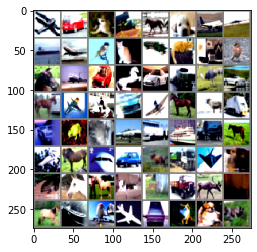

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Define Model

In [11]:
sys.path.append('/content/drive/MyDrive/CVMODEL/FindLR/Model/')

from model import Resnet_Architecture
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Resnet_Architecture(Model_Layers=18).to(device)

summary(model,input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Model Run

In [12]:

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from LRFinder import LR_Finder
Loss="CrossEntropyLoss"
EPOCHS = 2
model.device=dataloader.device
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrfinder = LR_Finder(optimizer)
optimizer, scheduler = lrfinder.range_test(start_lr=0.001, end_lr=1,num_iter=300,step_mode="exp", smooth_f=0.04, diverge_th=1)
#scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
model.gotrain(optimizer=optimizer, train_loader=trainloader, test_loader=testloader, epochs=EPOCHS, statspath=PROJECT_PATH+"/Save_Model/", scheduler=scheduler, batch_scheduler=lrfinder, L1lambda=0, LossType=Loss)


Batch=28 Loss=2.2900 Acc=18.81%:   3%|▎         | 26/782 [00:02<01:15, 10.00it/s]

Stopping early, the loss has diverged



  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 2.839249).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0345, Accuracy: 18.81%; Test set: Average loss: 2.8392, Accuracy: 15.22%
Learning Rate = 0.001905


Batch=56 Loss=2.0941 Acc=27.85%:   3%|▎         | 27/782 [00:02<01:10, 10.76it/s]

Stopping early, the loss has diverged


Epoch: 2, Train set: Average loss: 0.0296, Accuracy: 27.85%; Test set: Average loss: 3.4585, Accuracy: 23.83%
Learning Rate = 0.003548



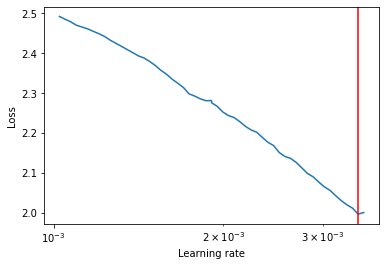

In [13]:

lrfinder.plot(title='LR_Finder_Curve', save_path=PROJECT_PATH+"/Save_Model/", skip_start=0, skip_end=0, log_lr=True, show_lr=lrfinder.best_learn)

In [14]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = Resnet_Architecture(name="Model_Res", Model_Layers=18)
model.to(dataloader.device)
Loss="CrossEntropyLoss"
EPOCHS = 50
model.device=dataloader.device
optimizer = optim.SGD(model.parameters(), lr=lrfinder.best_learn, weight_decay=0.0019 ,momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True, min_lr=1e-5)
#scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
model.gotrain(optimizer=optimizer, train_loader=trainloader, test_loader=testloader, epochs=EPOCHS, statspath=PROJECT_PATH+"/Save_Model/", scheduler=scheduler, batch_scheduler=False, L1lambda=0, LossType=Loss)

  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 1.376045).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0220, Accuracy: 48.95%; Test set: Average loss: 1.3760, Accuracy: 60.71%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (1.376045 --> 1.349125).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0157, Accuracy: 64.51%; Test set: Average loss: 1.3491, Accuracy: 62.01%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (1.349125 --> 0.810520).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0127, Accuracy: 71.87%; Test set: Average loss: 0.8105, Accuracy: 77.62%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.810520 --> 0.737016).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0112, Accuracy: 74.97%; Test set: Average loss: 0.7370, Accuracy: 79.32%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.737016 --> 0.697506).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0100, Accuracy: 77.78%; Test set: Average loss: 0.6975, Accuracy: 80.53%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.697506 --> 0.672675).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0093, Accuracy: 79.19%; Test set: Average loss: 0.6727, Accuracy: 81.77%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.672675 --> 0.633922).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0087, Accuracy: 80.91%; Test set: Average loss: 0.6339, Accuracy: 82.67%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.633922 --> 0.604524).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0082, Accuracy: 81.91%; Test set: Average loss: 0.6045, Accuracy: 83.56%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.604524 --> 0.572181).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0078, Accuracy: 82.75%; Test set: Average loss: 0.5722, Accuracy: 84.02%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.572181 --> 0.499361).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0074, Accuracy: 83.53%; Test set: Average loss: 0.4994, Accuracy: 86.27%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.499361 --> 0.498133).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0071, Accuracy: 84.45%; Test set: Average loss: 0.4981, Accuracy: 86.03%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.498133 --> 0.467528).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0068, Accuracy: 85.11%; Test set: Average loss: 0.4675, Accuracy: 86.67%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13, Train set: Average loss: 0.0065, Accuracy: 85.58%; Test set: Average loss: 0.4860, Accuracy: 86.66%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14, Train set: Average loss: 0.0064, Accuracy: 85.99%; Test set: Average loss: 0.4953, Accuracy: 86.89%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15, Train set: Average loss: 0.0061, Accuracy: 86.54%; Test set: Average loss: 0.4688, Accuracy: 86.92%
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16, Train set: Average loss: 0.0059, Accuracy: 87.11%; Test set: Average loss: 0.4923, Accuracy: 86.30%
Epoch    16: reducing learning rate of group 0 to 3.4674e-04.
Learning Rate = 0.003467


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.467528 --> 0.324305).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0044, Accuracy: 90.48%; Test set: Average loss: 0.3243, Accuracy: 90.87%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.324305 --> 0.313911).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0039, Accuracy: 91.86%; Test set: Average loss: 0.3139, Accuracy: 91.23%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.313911 --> 0.313447).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0038, Accuracy: 92.12%; Test set: Average loss: 0.3134, Accuracy: 91.58%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.313447 --> 0.306741).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0036, Accuracy: 92.53%; Test set: Average loss: 0.3067, Accuracy: 91.69%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 21, Train set: Average loss: 0.0034, Accuracy: 92.73%; Test set: Average loss: 0.3116, Accuracy: 91.88%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 22, Train set: Average loss: 0.0033, Accuracy: 93.27%; Test set: Average loss: 0.3126, Accuracy: 91.73%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.306741 --> 0.295164).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0032, Accuracy: 93.14%; Test set: Average loss: 0.2952, Accuracy: 91.94%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 24, Train set: Average loss: 0.0031, Accuracy: 93.42%; Test set: Average loss: 0.3055, Accuracy: 91.90%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.295164 --> 0.291732).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0031, Accuracy: 93.53%; Test set: Average loss: 0.2917, Accuracy: 91.96%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.291732 --> 0.290285).  Saving model ...
Epoch: 26, Train set: Average loss: 0.0030, Accuracy: 93.64%; Test set: Average loss: 0.2903, Accuracy: 92.04%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 27, Train set: Average loss: 0.0029, Accuracy: 93.80%; Test set: Average loss: 0.2990, Accuracy: 92.11%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 28, Train set: Average loss: 0.0029, Accuracy: 94.02%; Test set: Average loss: 0.2973, Accuracy: 91.90%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 29, Train set: Average loss: 0.0027, Accuracy: 94.29%; Test set: Average loss: 0.3008, Accuracy: 91.93%
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 30, Train set: Average loss: 0.0028, Accuracy: 94.27%; Test set: Average loss: 0.2950, Accuracy: 92.23%
Epoch    30: reducing learning rate of group 0 to 3.4674e-05.
Learning Rate = 0.000347


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.290285 --> 0.289766).  Saving model ...
Epoch: 31, Train set: Average loss: 0.0025, Accuracy: 94.89%; Test set: Average loss: 0.2898, Accuracy: 92.38%
Learning Rate = 0.000035


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.289766 --> 0.279839).  Saving model ...
Epoch: 32, Train set: Average loss: 0.0025, Accuracy: 94.82%; Test set: Average loss: 0.2798, Accuracy: 92.41%
Learning Rate = 0.000035


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss decreased (0.279839 --> 0.278521).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0025, Accuracy: 95.02%; Test set: Average loss: 0.2785, Accuracy: 92.51%
Learning Rate = 0.000035


Batch=26588 Loss=0.4131 Acc=94.91%: 100%|██████████| 782/782 [01:06<00:00, 11.68it/s]


Validation loss decreased (0.278521 --> 0.270187).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0025, Accuracy: 94.91%; Test set: Average loss: 0.2702, Accuracy: 92.49%
Learning Rate = 0.000035


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 35, Train set: Average loss: 0.0024, Accuracy: 95.05%; Test set: Average loss: 0.2915, Accuracy: 92.54%
Learning Rate = 0.000035


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 36, Train set: Average loss: 0.0024, Accuracy: 95.10%; Test set: Average loss: 0.2806, Accuracy: 92.70%
Learning Rate = 0.000035


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 37, Train set: Average loss: 0.0024, Accuracy: 95.10%; Test set: Average loss: 0.2853, Accuracy: 92.66%
Learning Rate = 0.000035


Batch=29716 Loss=0.1255 Acc=95.14%: 100%|██████████| 782/782 [01:06<00:00, 11.69it/s]


Validation loss decreased (0.270187 --> 0.265987).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 38, Train set: Average loss: 0.0024, Accuracy: 95.14%; Test set: Average loss: 0.2660, Accuracy: 92.64%
Learning Rate = 0.000035


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 39, Train set: Average loss: 0.0024, Accuracy: 95.14%; Test set: Average loss: 0.2858, Accuracy: 92.49%
Learning Rate = 0.000035


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 40, Train set: Average loss: 0.0024, Accuracy: 95.14%; Test set: Average loss: 0.2722, Accuracy: 92.52%
Learning Rate = 0.000035


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 41, Train set: Average loss: 0.0024, Accuracy: 95.10%; Test set: Average loss: 0.2716, Accuracy: 92.62%
Learning Rate = 0.000035


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 42, Train set: Average loss: 0.0024, Accuracy: 95.11%; Test set: Average loss: 0.2800, Accuracy: 92.54%
Epoch    42: reducing learning rate of group 0 to 1.0000e-05.
Learning Rate = 0.000035


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 43, Train set: Average loss: 0.0024, Accuracy: 95.30%; Test set: Average loss: 0.2848, Accuracy: 92.65%
Learning Rate = 0.000010


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 44, Train set: Average loss: 0.0023, Accuracy: 95.21%; Test set: Average loss: 0.2763, Accuracy: 92.74%
Learning Rate = 0.000010


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 45, Train set: Average loss: 0.0023, Accuracy: 95.34%; Test set: Average loss: 0.2727, Accuracy: 92.62%
Learning Rate = 0.000010


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 46, Train set: Average loss: 0.0024, Accuracy: 95.25%; Test set: Average loss: 0.2853, Accuracy: 92.61%
Learning Rate = 0.000010


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 47, Train set: Average loss: 0.0023, Accuracy: 95.17%; Test set: Average loss: 0.2777, Accuracy: 92.69%
Learning Rate = 0.000010


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 48, Train set: Average loss: 0.0024, Accuracy: 95.14%; Test set: Average loss: 0.2737, Accuracy: 92.67%
Learning Rate = 0.000010


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 49, Train set: Average loss: 0.0023, Accuracy: 95.24%; Test set: Average loss: 0.2779, Accuracy: 92.71%
Learning Rate = 0.000010


Batch=39100 Loss=0.5565 Acc=95.51%: 100%|██████████| 782/782 [01:06<00:00, 11.69it/s]


Epoch: 50, Train set: Average loss: 0.0023, Accuracy: 95.51%; Test set: Average loss: 0.2707, Accuracy: 92.72%
Learning Rate = 0.000010



3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [15]:
sys.path.append('/content/drive/MyDrive/CVMODEL/FindLR/Util/')
from Utils import *

In [16]:
class_acurracy(model, model.device, trainloader, classes)

Accuracy of plane : 96 %
Accuracy of   car : 97 %
Accuracy of  bird : 94 %
Accuracy of   cat : 92 %
Accuracy of  deer : 96 %
Accuracy of   dog : 92 %
Accuracy of  frog : 97 %
Accuracy of horse : 96 %
Accuracy of  ship : 97 %
Accuracy of truck : 97 %


# Get Sample of missclassified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


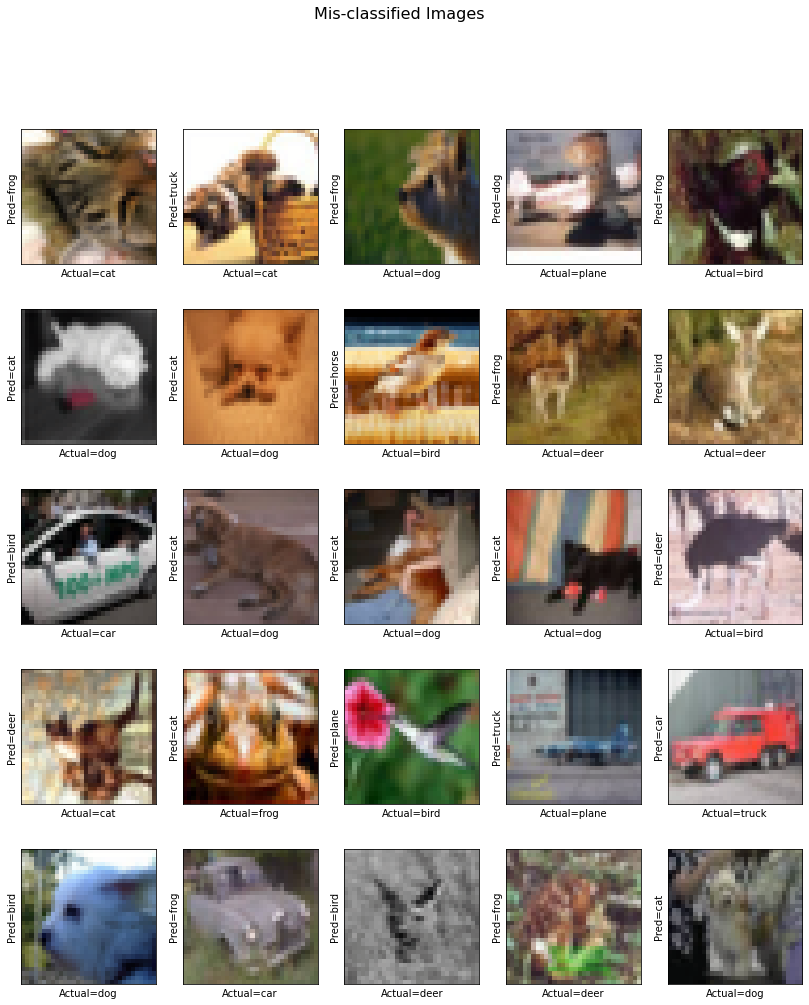

In [17]:
MisClassifiedImages, MisClassifiedPredLabels, MisClassifiedTargLabels = get_classified_images(model, model.device, testloader, classification='Miss')
show_classified(MisClassifiedImages, MisClassifiedPredLabels, MisClassifiedTargLabels, classes, mean, std,"Mis-classified Images",PROJECT_PATH+'/Save_Model/',25)

Get sample of Correct Classified Imgaes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


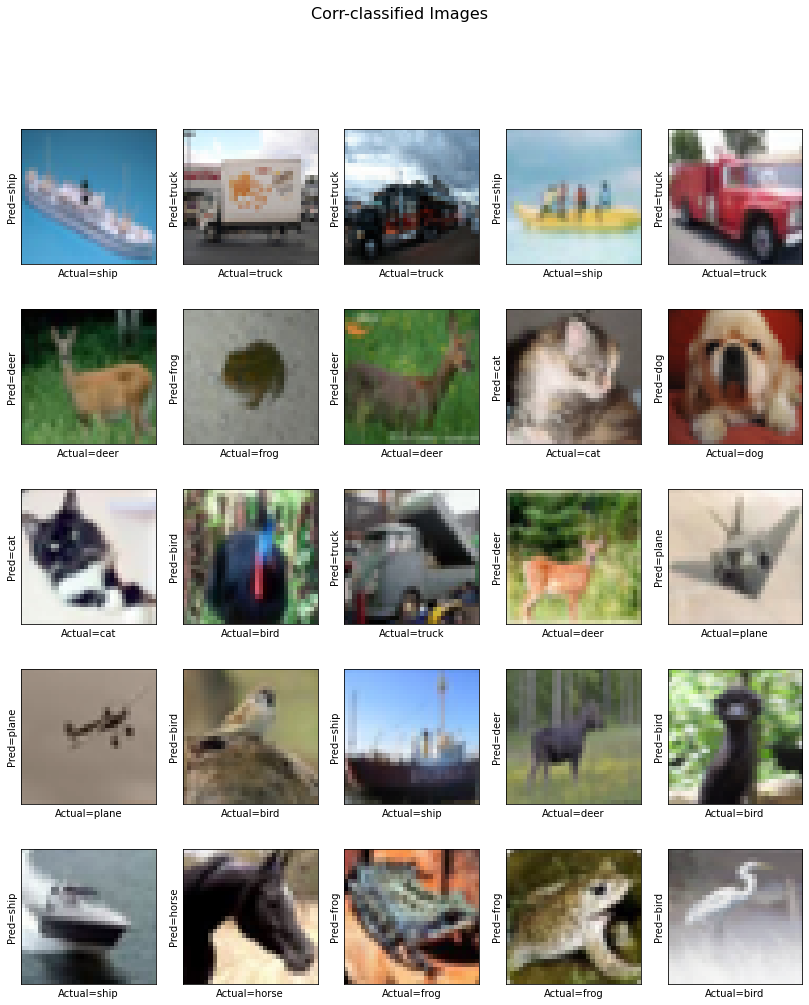

In [18]:

CorrClassifiedImages, CorrClassifiedPredLabels, CorrClassifiedTargLabels = get_classified_images(model, model.device, testloader, classification='Corr')
show_classified(CorrClassifiedImages, CorrClassifiedPredLabels, CorrClassifiedTargLabels, classes, mean, std,"Corr-classified Images",PROJECT_PATH+'/Save_Model/',25)

# getting ResNet Layers

In [19]:
for m,n in model.named_modules():
  print(m,n)

 Resnet_Architecture(
  (resnet_arch): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [ ]:
#Gradcam Incorrect Classification

torch.Size([25, 10])
Generating Grad-CAM @resnet_arch.layer1.0
Generating Grad-CAM @resnet_arch.layer2.0
Generating Grad-CAM @resnet_arch.layer3.0
Generating Grad-CAM @resnet_arch.layer4.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

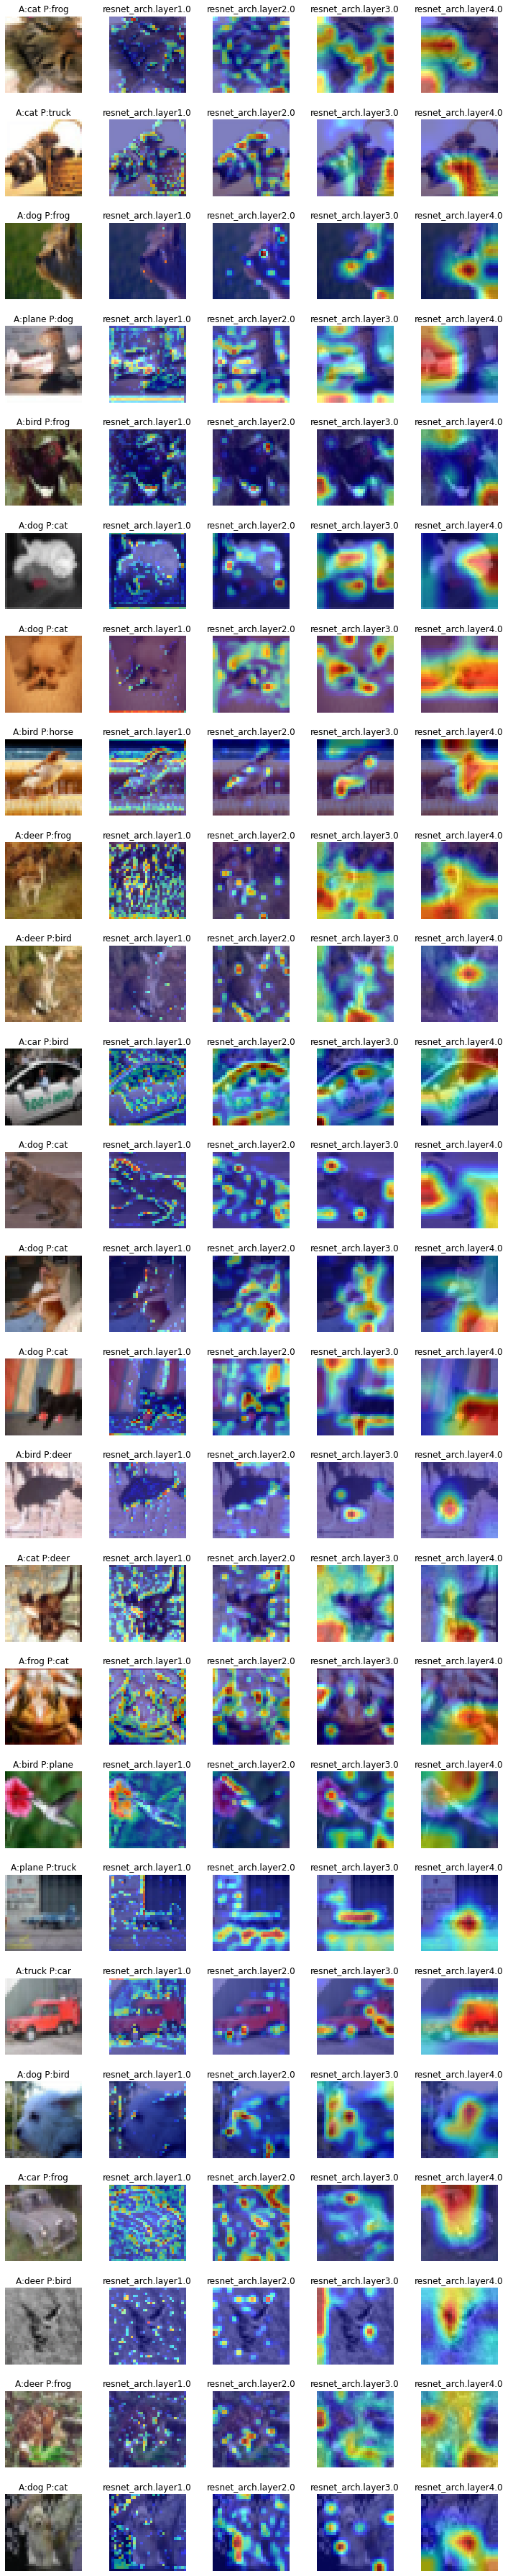

In [20]:
sys.path.append('/content/drive/MyDrive/CVMODEL/FindLR/Gradcam/')
from GradCam import VisualizeCam
target_layers = ["resnet_arch.layer1.0","resnet_arch.layer2.0","resnet_arch.layer3.0","resnet_arch.layer4.0"]
viz_cam = VisualizeCam(model, classes, target_layers)

viz_cam(MisClassifiedImages[:25], MisClassifiedTargLabels[:25], target_layers, mean, std, target_inds=MisClassifiedTargLabels[:25], metric="Incorrect", per_image=False, path=PROJECT_PATH+"/Save_Model/")

GradCam Correct Classification

torch.Size([25, 10])
Generating Grad-CAM @resnet_arch.layer1.0
Generating Grad-CAM @resnet_arch.layer2.0
Generating Grad-CAM @resnet_arch.layer3.0
Generating Grad-CAM @resnet_arch.layer4.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

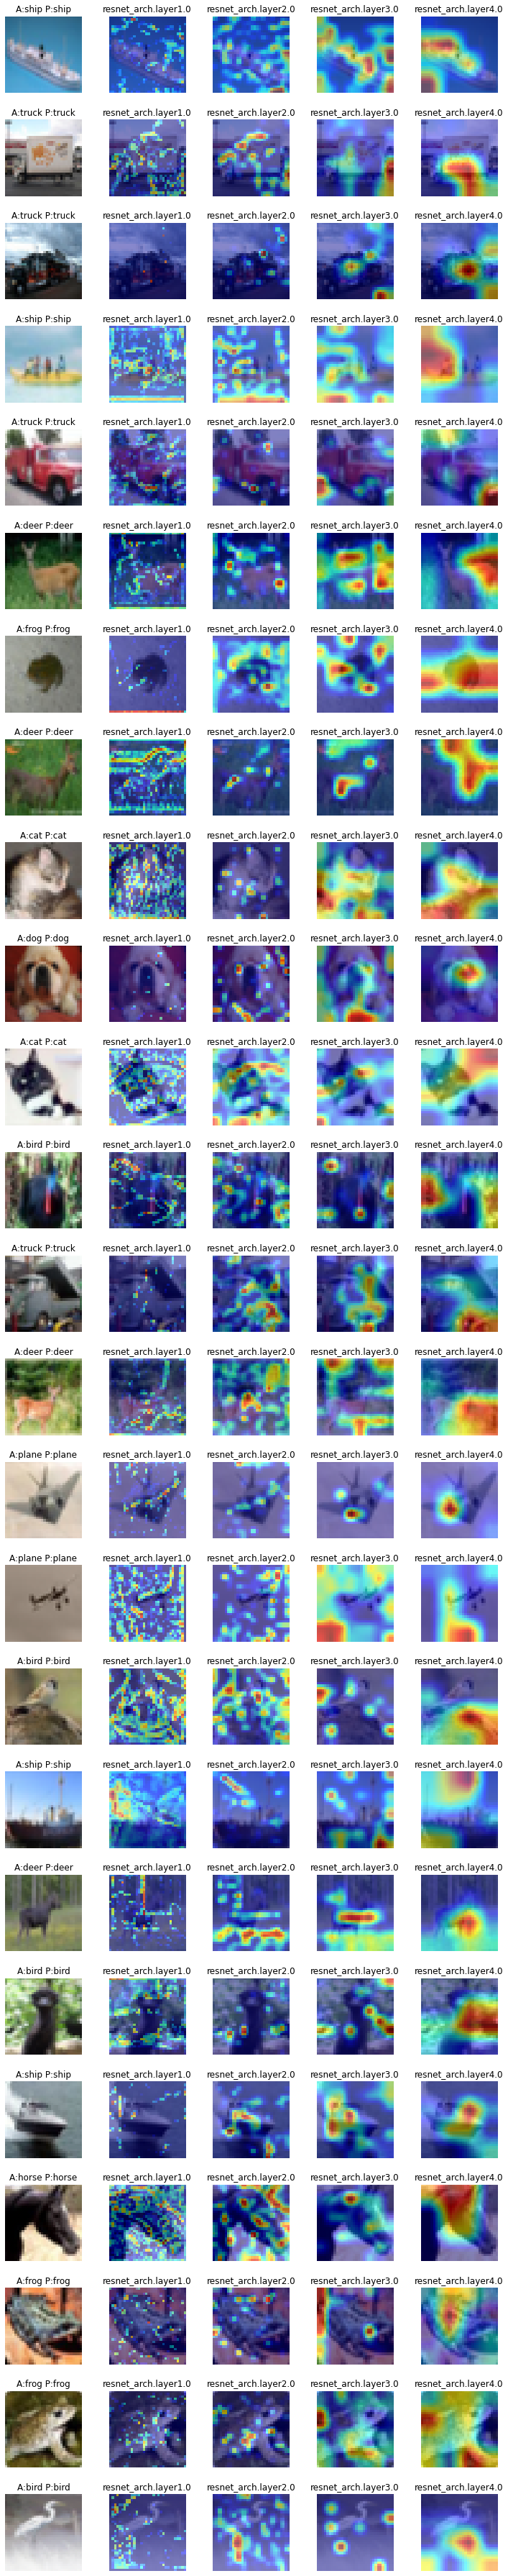

In [21]:
viz_cam(CorrClassifiedImages[:25], CorrClassifiedTargLabels[:25], target_layers, mean, std, target_inds=None, metric="Correct", per_image=False, path=PROJECT_PATH+"/Save_Model/")